# Early cancer detection using signature framework

On essaie ici de différentier les dynamiques malignes des dynamiques bénignes pour les biomarqueurs.

In [1]:
! apt-get install git
!git clone https://github.com/RemiVaucher/Thesis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Cloning into 'Thesis'...
remote: Enumerating objects: 457, done.
remote: Total 457 (delta 0), reused 0 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (457/457), 282.23 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (420/420), done.


In [ ]:
!pip install gudhi
!pip install signatory
!pip install iisignature
!pip install giotto-tda
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=11869519 sha256=e262a127ca7754665fdbfd6bb89067923b283deb122c562be77df57a0af1292f
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245486 sha256=7b4a26397cfa747eae23c005baad8b763f9ec0fd52b8124983fe0a2c0a37e80b
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.

In [ ]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gudhi
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.dtm_rips_complex import DTMRipsComplex
from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
import networkx as nx
from gtda.mapper import *
from sklearn.cluster import DBSCAN

In [2]:
import sys
%cd Thesis/Chapter4/Oncology/TDA/


from TDA_utils import corr_metric, compute_complex



/content/Thesis/Chapter4/Oncology/TDA


ModuleNotFoundError: No module named 'gudhi'

On importe les données bénignes:

In [ ]:
if local:
  path = 'G://Mon Drive/Etude_Cancer/TDA/Simul/benign_dwi_b'
else:
  path = "./Simul/benign_dwi_b"


data = {}
for b in [0.1,0.12,0.14,0.17]:
  df = pd.read_csv(path+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv(path+str(b)+".csv",sep = ";").to_numpy().T[1:,:,None])

torch.Size([4000, 7, 1])


<ipython-input-7-09a7c837e775>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T


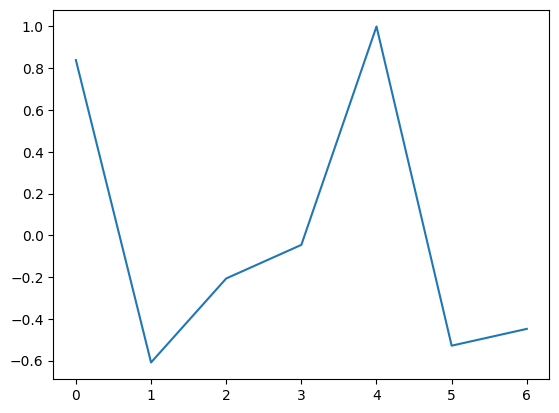

In [ ]:
scale = True
Time = False

data_ben = torch.cat((data['0.1'],data['0.12'],data['0.14'],data['0.17']))[:,1:]
data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T
if scale:
  data_ben = data_ben/np.abs(data_ben[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]
times = time.repeat(data_ben.shape[0],1,1)
if Time:
  data_ben= torch.cat((times,data_ben),axis = -1)

print(data_ben.shape)
plt.plot(data_ben[0,:])

In [ ]:
import os
import re


def starts_with_benign(s):
    return s.startswith("benign")
def starts_with_des(s):
    return s.startswith("desk")
classif = []
data_ben_mal = {}
if local:
  directory = 'G://Mon Drive/Etude_Cancer/TDA/Simul/'
else:
  directory = "./Simul/"

for filename in os.listdir(directory):
    if starts_with_benign(filename) or starts_with_des(filename):
      i = 1
    else:
      f = os.path.join(directory, filename)
      data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[1:,:,None])



In [ ]:
data_mal = torch.cat(tuple([data_ben_mal[filename] for filename in data_ben_mal.keys()]))
data_mal[:,:,0] = (data_mal[:,:,0].T-data_mal[:,:,0].mean(axis=1)).T
if scale:
  data_mal = data_mal/np.abs(data_mal[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]
times = time.repeat(data_mal.shape[0],1,1)
if Time:
  data_mal = torch.cat((times,data_mal),axis = -1)

print(data_mal.shape)

torch.Size([66000, 7, 1])


[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49 1000 1001 1002 1003 1004 1005
 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019
 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033
 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047
 1048 1049 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 3000 3001 3002 3003
 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013 3014 3015 3016 3017
 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030 3031
 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3044 3045
 3046 

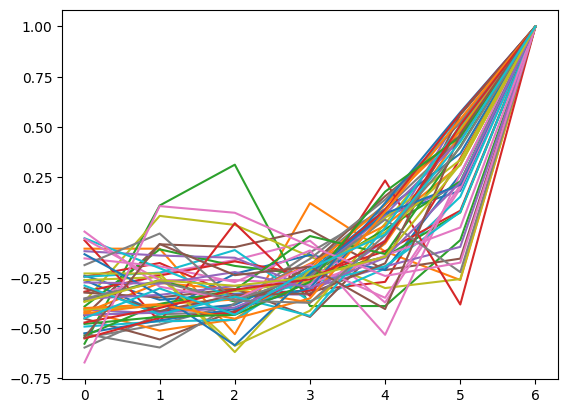

In [ ]:
rang = 50

idx = [i for i in range(rang)]
list_samples = [0,1,2,3,4,5,6,7,8,9]
num_samples = 20
for k in range(1,num_samples):
  idx += [i+k*1000 for i in range(rang)]
idx = np.array(idx)

classe = [0 for i in range(4*rang)]
for k in range(num_samples-4):
  classe += [k+1 for i in range(rang)]

classe = np.array(classe)

data_all = torch.cat((data_ben,data_mal))[idx,:]
print(idx[:250])
plt.plot(data_all[rang*5:rang*6,:,0].T)

In [ ]:
TD = TimeDelayEmbedding(dim=2,delay=1,skip = 1)
test = torch.tensor(TD.transform(data_all))
test.shape

<ipython-input-11-3fbe02b24278>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test = torch.tensor(TD.transform(data_all))


torch.Size([1000, 6, 2])

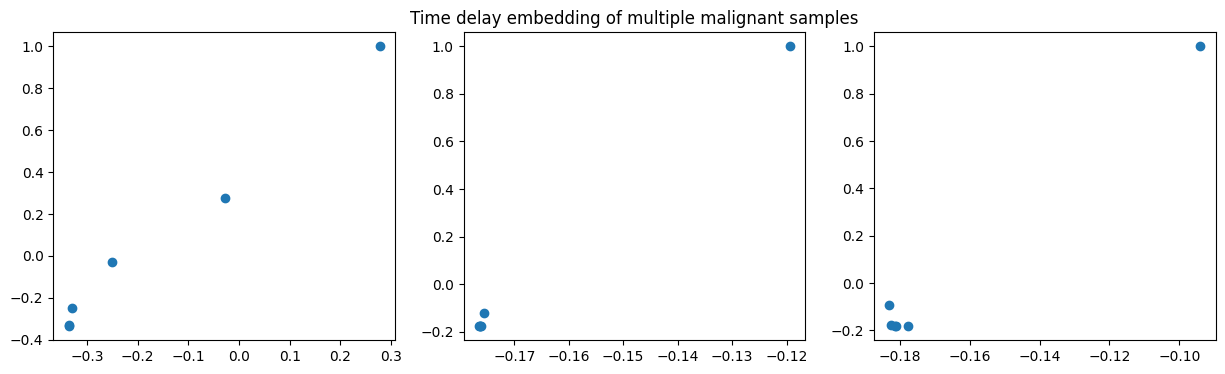

In [ ]:
i=220
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(test[i,:,0],test[i,:,1])
ax[1].scatter(test[i+150,:,0],test[i+150,:,1])
ax[1].set_title("Time delay embedding of multiple malignant samples")
ax[2].scatter(test[-1,:,0],test[-1,:,1])


In [ ]:
pers = []
pers0 = []
pers1 = []
pers2 = []
pers3 = []
dim = 2
for i in range(test.shape[0]):
  comp = gudhi.RipsComplex(points = test[i],max_edge_length = 1000).create_simplex_tree(max_dimension = dim)
  #comp = gudhi.AlphaComplex(points = test[i]).create_simplex_tree()
  #comp = DTMRipsComplex(points = test[i]).create_simplex_tree(max_dimension = dim)
  pers.append(comp.persistence())
  pers0.append(comp.persistence_intervals_in_dimension(0))
  pers1.append(comp.persistence_intervals_in_dimension(1))
  pers2.append(comp.persistence_intervals_in_dimension(2))
  if dim>3:
    pers3.append(comp.persistence_intervals_in_dimension(3))

In [ ]:
from  gudhi.wasserstein import wasserstein_distance

distance = wasserstein_distance
#distance = gudhi.bottleneck_distance

l = test.shape[0]
B0 = np.zeros((l,l))
B1 = np.zeros((l,l))
B2 = np.zeros((l,l))
B3 = np.zeros((l,l))

for i in range(l):
  for j in range(i):
    B0[i,j] = distance(pers0[i],pers0[j])
    #B1[i,j] = distance(pers1[i],pers1[j])
    #B2[i,j] = distance(pers1[i],pers1[j])
    if dim>3:
      B3[i,j] = distance(pers1[i],pers1[j])

B0 += B0.transpose()
B1 += B1.transpose()
B2 += B2.transpose()
B3 += B3.transpose()

In [ ]:
np.isinf(B0)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
from sklearn import manifold

def chose_method(method,dim_to_plot):
  if method == 0:
    met = manifold.MDS(
        n_components= 3,
        max_iter = 3000,
        eps = 1e-9,
        dissimilarity= "precomputed",
        n_jobs = 1
    )
    method_name = "MDS"

  if method == 1:
    met = manifold.SpectralEmbedding(
        n_components = 3,
        affinity = "precomputed",
        eigen_solver = "arpack"
    )
    method_name = "Spectral Embedding"

  if method == 2:
    met = manifold.TSNE(
        n_components = 3,
      metric = "precomputed",
        init = "random"
    )
    method_name = "t-SNE"

  if method == 3:
    met = manifold.LocallyLinearEmbedding(
        n_components = 3,
        n_neighbors = 10,
        method = "standard"
    )
    method_name = "LLE"

  if method == 4:
    met = manifold.Isomap(
        n_components = 3,
        n_neighbors = 10
    )
    method_name = "Isomap"

  if dim_to_plot == 1:
    pos0 = met.fit(B0).embedding_
  elif dim_to_plot == 2:
    pos0 = met.fit(B1).embedding_
  elif dim_to_plot == 3:
    pos0 = met.fit(B2).embedding_
  if dim>3:
    pos3 = met.fit(B3).embedding_

  return pos0, method_name

In [ ]:
import seaborn as sns

col = sns.color_palette("flare", num_samples-3)
col2 = sns.color_palette("bright", 10)[-2]
col2

(1.0, 0.7686274509803922, 0.0)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


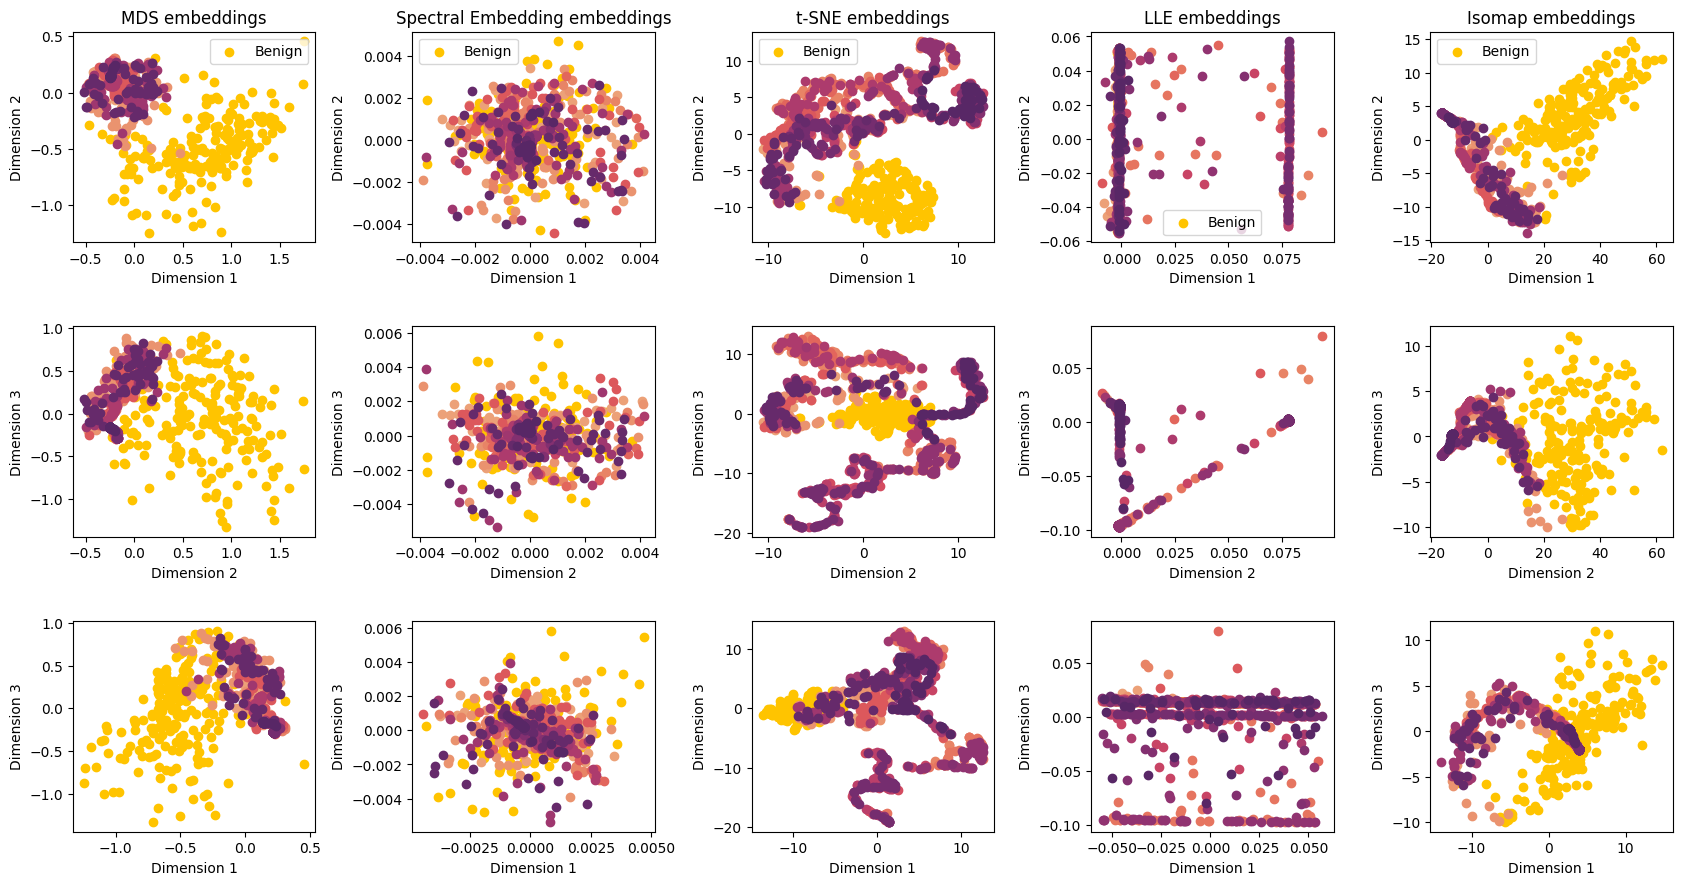

'\n\n  ax = fig.add_subplot(4, 5, (3,method), projection=\'3d\')\n  for k in range(num_samples):\n    if k<4:\n      ax.scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = cols[0],label = "Benign")\n    else:\n      ax.scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = cols[k], label = "Malignant")#plt.legend()\n  ax.set_xlabel("Dimension 1")\n  ax.set_ylabel("Dimension 2")\n  ax.set_zlabel("Dimension 3")\n  #axs[2,method].title(method_name+" embedding of persistence diagrams")\n'

In [ ]:
import matplotlib.colors as mcolors
import seaborn as sns

fig, ax = plt.subplots(3,5,figsize= (20,10))#plt.figaspect(0.5))
for method in range(5):
  pos0, method_name = chose_method(method,dim_to_plot = 1)

  cols = sns.color_palette("flare", num_samples-4)
  #list(mcolors.TABLEAU_COLORS)

  for k in range(num_samples):
    if k<4:
      if k==0:
        ax[0,method].scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1], color = col2,label = "Benign")
      else:
        ax[0,method].scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1], color = col2)
    else:
      ax[0,method].scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1], color = cols[k-4])
  #plt.legend(loc = 'lower right')
  ax[0,method].set_xlabel("Dimension 1")
  ax[0,method].set_ylabel("Dimension 2")
  ax[0,method].set_title(method_name+" embeddings")
  ax[0,method].legend()


  for k in range(num_samples):
    if k<4:
      ax[1,method].scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,2], color = col2,label = "Benign")
    else:
      ax[1,method].scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,2], color = cols[k-4], label = "Malignant")#plt.legendloc = ()
  ax[1,method].set_xlabel("Dimension 2")
  ax[1,method].set_ylabel("Dimension 3")
  #axs[1,method].title(method_name+" embedding of persistence diagrams")



  for k in range(num_samples):
    if k<4:
      ax[2,method].scatter(pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = col2,label = "Benign")
    else:
      ax[2,method].scatter(pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = cols[k-4], label = "Malignant")#plt.legendloc = ()
  ax[2,method].set_xlabel("Dimension 1")
  ax[2,method].set_ylabel("Dimension 3")



plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()


'''

  ax = fig.add_subplot(4, 5, (3,method), projection='3d')
  for k in range(num_samples):
    if k<4:
      ax.scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = cols[0],label = "Benign")
    else:
      ax.scatter(pos0[k*rang:(k+1)*rang,0],pos0[k*rang:(k+1)*rang,1],pos0[k*rang:(k+1)*rang,2], color = cols[k], label = "Malignant")#plt.legend()
  ax.set_xlabel("Dimension 1")
  ax.set_ylabel("Dimension 2")
  ax.set_zlabel("Dimension 3")
  #axs[2,method].title(method_name+" embedding of persistence diagrams")
'''

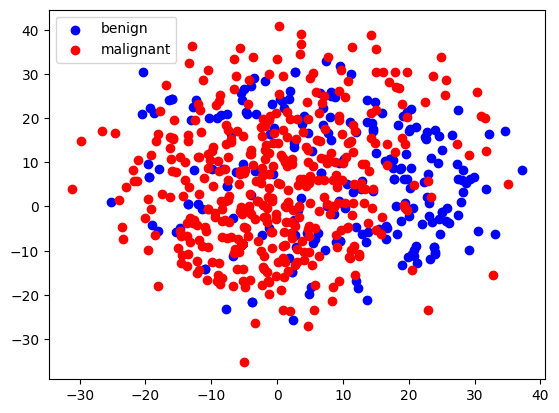

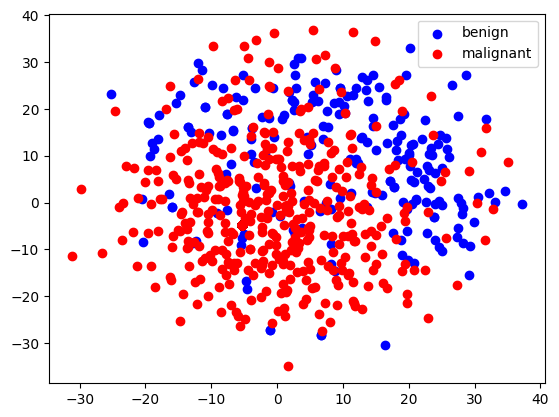

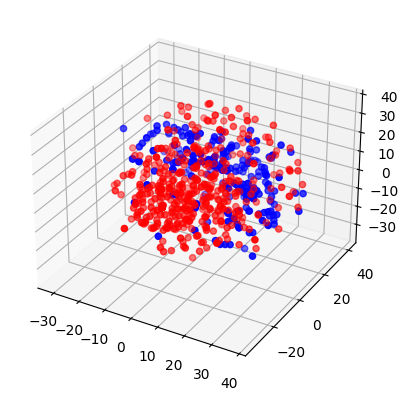

In [ ]:
plt.scatter(pos1[:250,0],pos1[:250,1],c = "blue",label = "benign")
plt.scatter(pos1[250:,0],pos1[250:,1],c = "red",label = "malignant")
plt.legend()
plt.show()

plt.scatter(pos1[:250,0],pos1[:250,2],c = "blue",label = "benign")
plt.scatter(pos1[250:,0],pos1[250:,2],c = "red",label = "malignant")
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos1[:250,0],pos1[:250,1],pos1[:250,2], color = "blue",label = "benign")
ax.scatter(pos1[250:,0],pos1[250:,1],pos1[250:,2], color = "red",label = "maignant")